In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, LayerNormalization, Input, Dropout


# Function Definitions

In [8]:
def z_score(arr, axis = 0):
    '''
        Transform 2d array to zero mean unit variance data along the time axis (2nd dim).
        
    '''
    
    means = np.mean(arr, axis = 0, keepdims = True)
    stds = np.std(arr, axis = 0, keepdims = True)
    
    arr -= means
    arr /= stds
    
    return arr

def evaluate_model(Y_pred, Y_true, metric = 'mse'):
    '''
    Evaluate a set of predictions Y_pred, comparing to Y_true true images. Return the
    average percent error over the set
    '''
    num_samples = Y_pred.shape[0]

    if metric == 'mse':
        pct_errs  = np.divide(np.linalg.norm(Y_pred - Y_true, axis = 1), np.linalg.norm(Y_true, axis = 1))
        
    return np.sum(pct_errs) / num_samples

def get_feedforward_model(params, num_pixels, num_neurons):
    '''
    Generate a feedforward deep neural network that maps neuron input to pixel intensity output. 
    ## TODO comment
    '''   

    (learning_rate, beta_1, beta_2, depth, width, loss) =(
    params['learning_rate'], params['beta_1'], params['beta_2'], params['depth'], params['width'], params['loss']
    )
    
    
    
    inputs = keras.Input(shape = (num_neurons,))
    for j in range(depth):
        if j == 0:
            x = Dense(units = width)(inputs)
        else:
            x = Dense(units = width)(x)
        x = LayerNormalization()(x)

    outputs = Dense(units = num_pixels)(x)

    model = Model(inputs = inputs, outputs = outputs)

    
    
    model.compile(
        optimizer = keras.optimizers.Adam(
            learning_rate = learning_rate,
            beta_1 = beta_1,
            beta_2 = beta_2
        ), 
        loss = loss
    )
    
    return model

# Load Data from Preprocessing

In [9]:
file_name_spikes = 'spike_rates_width=167.0_ms.npy'
file_name_frames = 'stimulus_frames.npy'

X = z_score(np.load(file_name_spikes))
Y = np.load(file_name_frames)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state = 1)

num_pixels = Y_train.shape[1]
num_neurons = X_train.shape[1]

# Feedforward Deep Network

In [10]:
params = {
    'learning_rate' : .001,
    'beta_1' : .99,
    'beta_2' : .999,
    'depth' : 10,
    'width' : 32,
    'loss' : keras.losses.MeanSquaredError()
}

model = get_feedforward_model(params, num_pixels, num_neurons)

#gridsearch learning rate, width, depth
num_epochs  = 1000

# number of learning rate values to explore (log scale)
lr_res = 10  

# number of depths to explore (log scale)
depth_res = 10 


# number of hidden layer widhts to explore
width_res = 10

learning_rates =  np.logspace(-5, -.1, num = lr_res)
depths = np.logspace(0, 2, num = depth_res).astype(np.int)
widths = np.logspace(1, 3, num = 10)


sweep_lr_d = False
if sweep_lr_d:
    performances = np.zeros((lr_res, depth_res))

    for i, lr in enumerate(learning_rates):
        for j, d in enumerate(depths):
            search_params = params.copy()
            search_params['learning_rate'] = lr
            search_params['depth'] = d
            
            model = get_feedforward_model(params, num_pixels, num_neurons)(search_params)
            model.fit(X_train, Y_train, epochs=1000)
            
            y_hat_train = model.predict(X_train)
            performances[i,j] = evaluate_model(y_hat_train, Y_train)

            
            
# Empircal Results so far
best_rate = learning_rates[2]
best_depth = depths[4]
best_width = widths[4]

sweep_w = False
if sweep_w:
    
    performances = np.zeros((width_res,))
    for i, w in enumerate(widths):
        search_params = params.copy()
        search_params['learning_rate'] = best_rate
        search_params['depth'] = best_depth
        search_params['width'] = w
        
        model = get_feedforward_model(params, num_pixels, num_neurons)(search_params)
        model.fit(X_train, Y_train, epochs=1000)

        y_hat_train = model.predict(X_train)
        performances[i] = evaluate_model(y_hat_train, Y_train)

        
train_best_model = False
if train_best_model:
            
    best_params = params.copy()
    best_params['learning_rate'] = best_rate
    best_params['depth'] = best_depth
    best_params['width'] = best_width
    best_params['loss'] = 'mse'

    model = get_feedforward_model(best_params, num_pixels, num_neurons)
    model.fit(X_train, Y_train, epochs = 50000, verbose = 1)
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)

    train_error =  evaluate_model(y_hat_train, Y_train)
    test_error = evaluate_model(y_hat_test, Y_test)
    
    print('Feedforward Deep Net Train Error: {0}'.format(train_error))
    print('Feedforward Deep Net Test Error: {0}'.format(test_error))

model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 758)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                24288     
_________________________________________________________________
layer_normalization (LayerNo (None, 32)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
layer_normalization_1 (Layer (None, 32)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
layer_normalization_2 (Layer (None, 32)                64    

In [16]:
# Save / Load Existing Trained Model
#model.save('ff_deep_net_trained')
#model = keras.models.load_model('ff_deep_net_trained')


In [13]:
# Evaluate Feedforward Deep Net

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

train_error =  evaluate_model(y_hat_train, Y_train, metric='mse')
test_error = evaluate_model(y_hat_test, Y_test, metric='mse')

print('Feedforward Deep Net Train Error: {0}'.format(train_error))
print('Feedforward Deep Net Test Error: {0}'.format(test_error))


filters = np.linalg.pinv(X_train) @ Y_train
train_error = evaluate_model(X_train @ filters, Y_train, metric='mse')
test_error = evaluate_model(X_test @ filters, Y_test, metric ='mse')

print('Linear Decoder Train Error: {0}'.format(train_error))
print('Linear Decoder Test Error: {0}'.format(test_error))

Feedforward Deep Net Train Error: 0.44482939267713506
Feedforward Deep Net Test Error: 0.4654473744748111
Linear Decoder Train Error: 0.5990459767547462
Linear Decoder Test Error: 0.604695827425791


In [18]:
train_error = evaluate_model(np.random.normal(scale = np.mean(np.std(Y_train, axis =1)), loc = 0, size = y_hat_train.shape), Y_train, metric='mse')
test_error = evaluate_model(np.random.normal(scale = np.mean(np.std(Y_train, axis =1)), loc = 0, size = y_hat_test.shape), Y_test, metric ='mse')

print('Random Image Train Error: {0}'.format(train_error))
print('Random Image Test Error: {0}'.format(test_error))


Random Image Train Error: 1.4213450048712593
Random Image Test Error: 1.4203672009279065


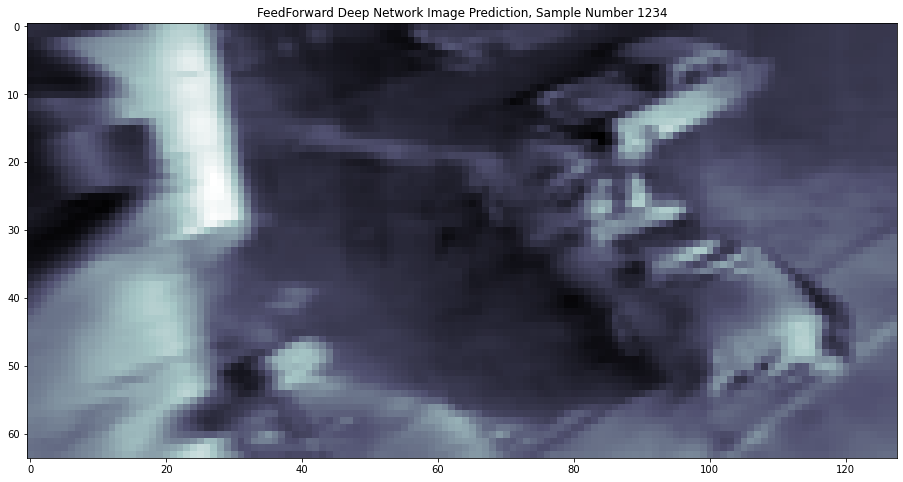

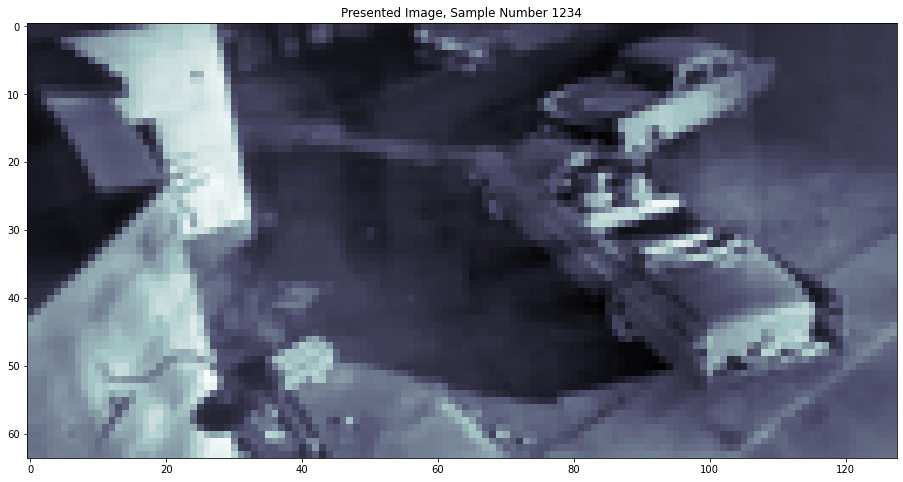

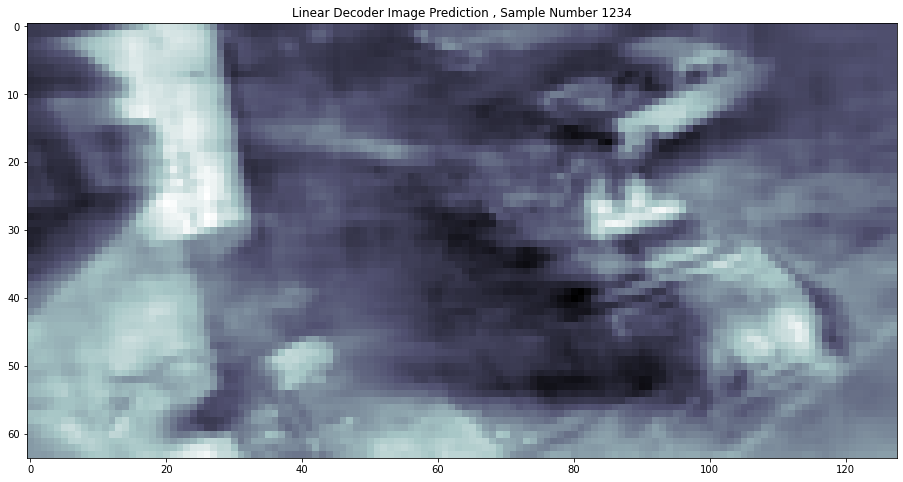

In [27]:
sample_num = 1234
y_hat_test = model.predict(X_test)

plt.figure(figsize=(16,8))
plt.imshow(y_hat_test[sample_num,:].reshape(64, 128), cmap = 'bone')
plt.title('FeedForward Deep Network Image Prediction, Sample Number {0}'.format(sample_num))
plt.savefig('c.png')
plt.show()

plt.figure(figsize=(16,8))
plt.imshow(Y_test[sample_num, :].reshape(64, 128), cmap = 'bone')
plt.title('Presented Image, Sample Number {0}'.format(sample_num))
plt.savefig('a.png')
plt.show()

plt.figure(figsize=(16,8))
plt.imshow((X_test @ filters)[sample_num, :].reshape(64, 128), cmap = 'bone')
plt.title('Linear Decoder Image Prediction , Sample Number {0}'.format(sample_num))
plt.savefig('b.png')
plt.show()